# Notes Agent

## Setting up llm

In [2]:
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph

In [3]:
load_dotenv()

True

In [4]:
llm = ChatOpenAI(openai_api_key=os.getenv("OPENAI_API_KEY"), model="gpt-4o")

llm.invoke("Hi how are you")

## Sample Graph

In [5]:
from langgraph.graph import MessagesState

class OverallState(MessagesState):
    pass

In [6]:
def node_1(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"])]}

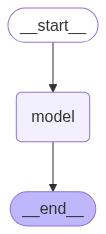

In [27]:
from IPython.display import Image as ImageDisplay, display
from langgraph.graph import StateGraph, START, END

builder = StateGraph(OverallState)

builder.add_node("model", node_1)

builder.add_edge(START, "model")
builder.add_edge("model", END)

graph = builder.compile()

display(ImageDisplay(graph.get_graph().draw_mermaid_png()))

In [8]:
graph.invoke({"messages": ["hi"]})

{'messages': [HumanMessage(content='hi', additional_kwargs={}, response_metadata={}, id='5a7107c2-36cf-4f08-95ac-6c6602055acd'),
  AIMessage(content='Hello! How can I help you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 8, 'total_tokens': 17, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_07871e2ad8', 'id': 'chatcmpl-BmahxHbVprUOM5koUyIVkDb83yDK7', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--45cea7f1-73c3-4c8b-b87c-6ecf532da90a-0', usage_metadata={'input_tokens': 8, 'output_tokens': 9, 'total_tokens': 17, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}

## Sample reAct Agent

In [9]:
def add(a: int, b: int) -> int:
    """Add a and b

    Args:
        a: first int
        b: second int
    """
    return a + b

def subtract(a: int, b: int) -> int:
    """Subtract b from a, so (a - b)

    Args:
        a: first int
        b: second int
    """
    return a - b

def multiply(a: int, b: int) -> int:
    """Multiply a and b

    Args:
        a: first int
        b: second int
    """
    return a * b

def divide(a: int, b: int) -> int:
    """Divide a by b

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, subtract, multiply, divide]
llm = ChatOpenAI(model="gpt-3.5-turbo")
llm_with_tools = llm.bind_tools(tools)

In [10]:
from langchain_core.messages import HumanMessage, SystemMessage

sys_message = SystemMessage(content="You are an assistant that is tasked with performing basic four function math calculations. Take the expression given to you and find the smallest expression that you can calculate with the given numbers. Calculate that expression ONLY then get the value, then try to find the next smallest expression you can calculate and repeat. Do not perform multiple tool calls before getting responses for preceeding ones, one tool call at a time and get a response from a tool call before issuing another one.")

def model_node(state: MessagesState):
    return {"messages": [llm_with_tools.invoke([sys_message] + state["messages"])]}

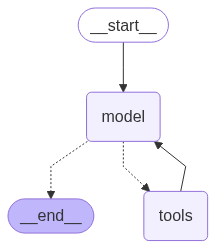

In [11]:
from langgraph.prebuilt import tools_condition, ToolNode

builder = StateGraph(OverallState)

builder.add_node("model", model_node)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "model")
builder.add_conditional_edges("model", tools_condition)

builder.add_edge("tools", "model")

react_model = builder.compile()

display(Image(react_model.get_graph(xray=True).draw_mermaid_png()))

In [12]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
react_graph_memory = builder.compile(checkpointer = memory)

config = {"configurable": {"thread_id": 1}}

message = [HumanMessage(content="Add 3 and 12, and multiply that by 2 and divide the entire thing by 10, then finally subtract 10")]

messages = react_graph_memory.invoke({"messages": message}, config)

for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 12, and multiply that by 2 and divide the entire thing by 10, then finally subtract 10
================================== Ai Message ==================================
Tool Calls:
  add (call_Cz0dL4IB8rGr87Gof8nOBB4F)
 Call ID: call_Cz0dL4IB8rGr87Gof8nOBB4F
  Args:
    a: 3
    b: 12
================================= Tool Message =================================
Name: add

15
================================== Ai Message ==================================
Tool Calls:
  multiply (call_IZ6PVo9uA1CFBDVV7Gs2Ngbn)
 Call ID: call_IZ6PVo9uA1CFBDVV7Gs2Ngbn
  Args:
    a: 15
    b: 2
  divide (call_k7wmCVrqBLLAC7ljl5CW08Vy)
 Call ID: call_k7wmCVrqBLLAC7ljl5CW08Vy
  Args:
    a: 30
    b: 10
================================= Tool Message =================================
Name: multiply

30
================================= Tool Message =================================
Name: divide

3.0
=================

## PDF Image Extraction

In [40]:
import fitz
import io
from PIL import Image
import os
import base64

llm = ChatOpenAI(openai_api_key=os.getenv("OPENAI_API_KEY"), model="gpt-4o")

file = "./ai_agent_notes.pdf"

pdf_file = fitz.open(file)
result = []

for page_index in range(len(pdf_file)):
    page = pdf_file.load_page(page_index)
    page.clean_contents()
    image_list = page.get_images(full = True)
    image_rects = []

    if image_list:
        print(f"Found {len(image_list)} images on page {page_index}")
    else:
        print(f"No images on page {page_index}")

    for image_index, img in enumerate(image_list, start = 1):
        xref = img[0]

        rects = page.get_image_rects(xref)
        
        base_image = pdf_file.extract_image(xref)
        image_bytes = base_image["image"]

        image_ext = base_image["ext"]

        image_name = f"image{page_index + 1}_{image_index}.{image_ext}"
        image_path = os.path.join("images", image_name)

        if rects:
            image_rects.append((rects, image_path))

        with open(image_path, "wb") as image_file:
            image_file.write(image_bytes)
            print(f"Image saved as {image_name}")

    words = page.get_text("words")
    sorted_words = sorted(words, key = lambda w: (w[1], w[0]))

    if page_index > 0:
        page_prev = pdf_file.load_page(page_index - 1)
        prev_words = page_prev.get_text("words")
        sorted_prev_words = sorted(prev_words, key = lambda w: (w[1], w[0]))
    else:
        sorted_prev_words = []

    if page_index < len(pdf_file) - 1:
        page_post = pdf_file.load_page(page_index + 1)
        post_words = page_post.get_text("words")
        sorted_post_words = sorted(post_words, key = lambda w: (w[1], w[0]))
    else:
        sorted_post_words = []
        
    for image_rect in image_rects:
        rect, image_name = image_rect
        rect = rect[0]

        above_words = []
        below_words = []

        for word in sorted_words:
            word_text = word[4]
            word_y = (word[1] + word[3]) / 2
            image_y0, image_y1 = rect.y0, rect.y1

            if word_y < image_y0:
                above_words.append((word[0], word[1], word_text))
            elif word_y > image_y1:
                below_words.append((word[0], word[1], word_text))

        above_words = [word[2] for word in sorted(above_words, key=lambda x: (-x[1], -x[0]))][:15][::-1]
        below_words = [word[2] for word in sorted(below_words, key = lambda x: (x[1], x[0]))][:15]

        if len(above_words) < 15 and sorted_prev_words:
            above_words = [w[4] for w in sorted_prev_words][(-15 + len(above_words)):] + above_words

        if len(below_words) < 15 and sorted_post_words:
            below_words.extend([w[4] for w in sorted_post_words][:(15 - len(below_words))])

        result.append({
            "image_rect": image_name,
            "above": above_words,
            "below": below_words
        })

topic = "LangChain and LangGraph Notes"

for item in result:
    print(item)

    with open(item["image_rect"], "rb") as file:
        image_data = base64.b64encode(file.read()).decode("utf-8")

        prompt = f"""
You are an assistant that summarizes images for use in retrieval and reasoning chains.

Given the topic: "{topic}", and the image with nearby text, write a short 1–3 sentence description that clearly and concisely states:
- What the image visually shows (shapes, labels, flow)
- What concept it supports in the context of the topic (light interpretation only)

Avoid speculation. Focus on what's visible and its direct relevance to the topic.

Above: {" ".join(item['above'])}  
Below: {" ".join(item['below'])}  
Describe the image accordingly:
"""

    message = {
        "role": "user",
        "content": [
            {
                "type": "text",
                "text": prompt,
            },
            {
                "type": "image",
                "source_type": "base64",
                "data": image_data,
                "mime_type": "image/png",
            }
        ],
    }

    response = llm.invoke([message])
    print(response.text())



No images on page 0
No images on page 1
Found 4 images on page 2
Image saved as image3_1.png
Image saved as image3_2.png
Image saved as image3_3.png
Image saved as image3_4.png
Found 1 images on page 3
Image saved as image4_1.png
No images on page 4
No images on page 5
No images on page 6
No images on page 7
No images on page 8
No images on page 9
No images on page 10
No images on page 11
No images on page 12
No images on page 13
No images on page 14
No images on page 15
No images on page 16
No images on page 17
No images on page 18
No images on page 19
No images on page 20
No images on page 21
No images on page 22
No images on page 23
No images on page 24
No images on page 25
No images on page 26
No images on page 27
No images on page 28
No images on page 29
No images on page 30
No images on page 31
Found 1 images on page 32
Image saved as image33_1.png
No images on page 33
No images on page 34
No images on page 35
No images on page 36
No images on page 37
No images on page 38
No imag


KeyboardInterrupt



KeyboardInterrupt: 

In [48]:
# Grab All Images and Context -> Run Text Extraction and Interpretation (Map) -> Create Image Map (Reduce)
from typing import Annotated, Dict, List, Any
import fitz
import io
from PIL import Image
import os
import base64
from langgraph.constants import Send

llm = ChatOpenAI(openai_api_key=os.getenv("OPENAI_API_KEY"), model="gpt-4o")

def dict_reducer(old, new):
    return {**old, **new}

class OverallState(MessagesState):
    pdf_name: str
    image_map: Annotated[Dict[str, str], dict_reducer]
    image_list: List[Dict[str, Any]]
    topic: str

def parse_images(state: OverallState):
    file = "./" + state["pdf_name"]
    
    pdf_file = fitz.open(file)
    result = []
    
    for page_index in range(len(pdf_file)):
        page = pdf_file.load_page(page_index)
        page.clean_contents()
        image_list = page.get_images(full = True)
        image_rects = []
    
        if image_list:
            print(f"Found {len(image_list)} images on page {page_index}")
        else:
            print(f"No images on page {page_index}")
    
        for image_index, img in enumerate(image_list, start = 1):
            xref = img[0]
    
            rects = page.get_image_rects(xref)
            
            base_image = pdf_file.extract_image(xref)
            image_bytes = base_image["image"]
    
            image_ext = base_image["ext"]
    
            image_name = f"image{page_index + 1}_{image_index}.{image_ext}"
            image_path = os.path.join("images", image_name)
    
            if rects:
                image_rects.append((rects, image_path))
    
            with open(image_path, "wb") as image_file:
                image_file.write(image_bytes)
                print(f"Image saved as {image_name}")
    
        words = page.get_text("words")
        sorted_words = sorted(words, key = lambda w: (w[1], w[0]))
    
        if page_index > 0:
            page_prev = pdf_file.load_page(page_index - 1)
            prev_words = page_prev.get_text("words")
            sorted_prev_words = sorted(prev_words, key = lambda w: (w[1], w[0]))
        else:
            sorted_prev_words = []
    
        if page_index < len(pdf_file) - 1:
            page_post = pdf_file.load_page(page_index + 1)
            post_words = page_post.get_text("words")
            sorted_post_words = sorted(post_words, key = lambda w: (w[1], w[0]))
        else:
            sorted_post_words = []
            
        for image_rect in image_rects:
            rect, image_name = image_rect
            rect = rect[0]
    
            above_words = []
            below_words = []
    
            for word in sorted_words:
                word_text = word[4]
                word_y = (word[1] + word[3]) / 2
                image_y0, image_y1 = rect.y0, rect.y1
    
                if word_y < image_y0:
                    above_words.append((word[0], word[1], word_text))
                elif word_y > image_y1:
                    below_words.append((word[0], word[1], word_text))
    
            above_words = [word[2] for word in sorted(above_words, key=lambda x: (-x[1], -x[0]))][:15][::-1]
            below_words = [word[2] for word in sorted(below_words, key = lambda x: (x[1], x[0]))][:15]
    
            if len(above_words) < 15 and sorted_prev_words:
                above_words = [w[4] for w in sorted_prev_words][(-15 + len(above_words)):] + above_words
    
            if len(below_words) < 15 and sorted_post_words:
                below_words.extend([w[4] for w in sorted_post_words][:(15 - len(below_words))])
    
            result.append({
                "image_rect": image_name,
                "above": above_words,
                "below": below_words
            })

    return {"image_list": result}

def create_image_definition(state: dict):
    item = state["image"]
    
    with open(item["image_rect"], "rb") as file:
        image_data = base64.b64encode(file.read()).decode("utf-8")

        prompt = f"""
You are an assistant that summarizes images for use in retrieval and reasoning chains.

Given the topic: "{state["topic"]}", and the image with nearby text, write a short 1–3 sentence description that clearly and concisely states:
- What the image visually shows (shapes, labels, flow)
- What concept it supports in the context of the topic (light interpretation only)

Avoid speculation. Focus on what's visible and its direct relevance to the topic.

Above: {" ".join(item['above'])}  
Below: {" ".join(item['below'])}  
Describe the image accordingly:
"""

        message = {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": prompt,
                },
                {
                    "type": "image",
                    "source_type": "base64",
                    "data": image_data,
                    "mime_type": "image/png",
                }
            ],
        }
        
        response = llm.invoke([message])

        return {"image_map": {item["image_rect"]: response.text()}}

def generate_definitions(state: OverallState):
    return [Send("create_image_definition", {"image": img, "topic": state["topic"]}) for img in state["image_list"]]

def print_image_definitions(state: OverallState):
    for key, val in state["image_map"].items():
        print((key, val))    

    return {}

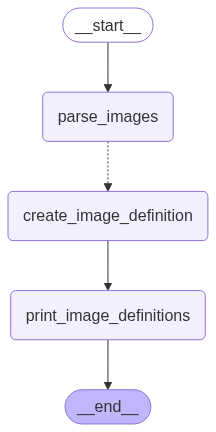

In [49]:
from langgraph.prebuilt import tools_condition, ToolNode

builder = StateGraph(OverallState)

builder.add_node(parse_images)
builder.add_node(create_image_definition)
builder.add_node(print_image_definitions)

builder.add_edge(START, "parse_images")
builder.add_conditional_edges("parse_images", generate_definitions, ["create_image_definition"])
builder.add_edge("create_image_definition", "print_image_definitions")
builder.add_edge("print_image_definitions", END)

image_definition_generator = builder.compile()

display(ImageDisplay(image_definition_generator.get_graph(xray=True).draw_mermaid_png()))

In [50]:
res = image_definition_generator.invoke({"pdf_name":"ai_agent_notes.pdf","image_map":{}, "image_list": [], "topic":"LangGraph and LangChain Notes"})

No images on page 0
No images on page 1
Found 4 images on page 2
Image saved as image3_1.png
Image saved as image3_2.png
Image saved as image3_3.png
Image saved as image3_4.png
Found 1 images on page 3
Image saved as image4_1.png
No images on page 4
No images on page 5
No images on page 6
No images on page 7
No images on page 8
No images on page 9
No images on page 10
No images on page 11
No images on page 12
No images on page 13
No images on page 14
No images on page 15
No images on page 16
No images on page 17
No images on page 18
No images on page 19
No images on page 20
No images on page 21
No images on page 22
No images on page 23
No images on page 24
No images on page 25
No images on page 26
No images on page 27
No images on page 28
No images on page 29
No images on page 30
No images on page 31
Found 1 images on page 32
Image saved as image33_1.png
No images on page 33
No images on page 34
No images on page 35
No images on page 36
No images on page 37
No images on page 38
No imag

KeyError: 'i.png'